# Ungraded Lab: Predicting Sunspots with Neural Networks

At this point in the course, you should be able to explore different network architectures for forecasting. In the previous weeks, you've used DNNs, RNNs, and CNNs to build these different models. In the final practice lab for this course, you'll try one more configuration and that is a combination of all these types of networks: the data windows will pass through a convolution, followed by stacked LSTMs, followed by stacked dense layers. See if this improves results or you can just opt for simpler models.

## Imports

In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import csv

2024-10-10 15:11:41.723261: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-10-10 15:11:41.737720: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-10-10 15:11:41.753024: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-10-10 15:11:41.757245: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-10-10 15:11:41.769811: I tensorflow/core/platform/cpu_feature_guar

## Utilities

In [2]:
def plot_series(x, y, format="-", start=0, end=None, 
                title=None, xlabel=None, ylabel=None, legend=None ):
    """
    Visualizes time series data

    Args:
      x (array of int) - contains values for the x-axis
      y (array of int or tuple of arrays) - contains the values for the y-axis
      format (string) - line style when plotting the graph
      start (int) - first time step to plot
      end (int) - last time step to plot
      title (string) - title of the plot
      xlabel (string) - label for the x-axis
      ylabel (string) - label for the y-axis
      legend (list of strings) - legend for the plot
    """

    # Setup dimensions of the graph figure
    plt.figure(figsize=(10, 6))
    
    # Check if there are more than two series to plot
    if type(y) is tuple:

      # Loop over the y elements
      for y_curr in y:

        # Plot the x and current y values
        plt.plot(x[start:end], y_curr[start:end], format)

    else:
      # Plot the x and y values
      plt.plot(x[start:end], y[start:end], format)

    # Label the x-axis
    plt.xlabel(xlabel)

    # Label the y-axis
    plt.ylabel(ylabel)

    # Set the legend
    if legend:
      plt.legend(legend)

    # Set the title
    plt.title(title)

    # Overlay a grid on the graph
    plt.grid(True)

    # Draw the graph on screen
    plt.show()

## Download and Preview the Dataset

In [3]:
# Download the Dataset
!wget -P data/ -nc https://storage.googleapis.com/tensorflow-1-public/course4/Sunspots.csv

File ‘data/Sunspots.csv’ already there; not retrieving.



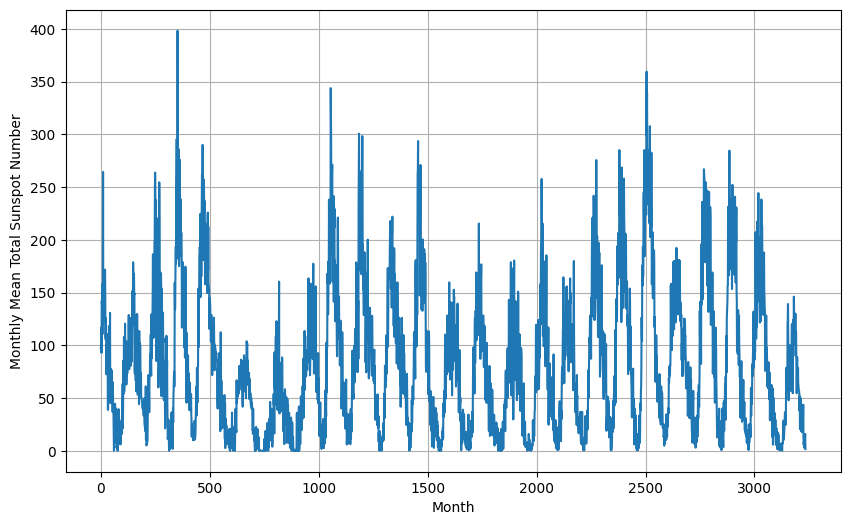

In [4]:
# Initialize lists
time_step = []
sunspots = []

# Open CSV file
with open('./data/Sunspots.csv') as csvfile:
  
  # Initialize reader
  reader = csv.reader(csvfile, delimiter=',')
  
  # Skip the first line
  next(reader)
  
  # Append row and sunspot number to lists
  for row in reader:
    time_step.append(int(row[0]))
    sunspots.append(float(row[2]))

# Convert lists to numpy arrays
time = np.array(time_step)
series = np.array(sunspots)

# Preview the data
plot_series(time, series, xlabel='Month', ylabel='Monthly Mean Total Sunspot Number')

## Split the Dataset

In [5]:
# Define the split time
split_time = 3000

# Get the train set 
time_train = time[:split_time]
x_train = series[:split_time]

# Get the validation set
time_valid = time[split_time:]
x_valid = series[split_time:]

## Prepare Features and Labels

In [6]:
def windowed_dataset(series, window_size, batch_size, shuffle_buffer):
    """Generates dataset windows

    Args:
      series (array of float) - contains the values of the time series
      window_size (int) - the number of time steps to include in the feature
      batch_size (int) - the batch size
      shuffle_buffer(int) - buffer size to use for the shuffle method

    Returns:
      dataset (TF Dataset) - TF Dataset containing time windows
    """

    # Add an axis for the feature dimension of RNN layers
    series = tf.expand_dims(series, axis=-1)
    
    # Generate a TF Dataset from the series values
    dataset = tf.data.Dataset.from_tensor_slices(series)
    
    # Window the data but only take those with the specified size
    dataset = dataset.window(window_size + 1, shift=1, drop_remainder=True)
    
    # Flatten the windows by putting its elements in a single batch
    dataset = dataset.flat_map(lambda window: window.batch(window_size + 1))

    # Create tuples with features and labels 
    dataset = dataset.map(lambda window: (window[:-1], window[-1]))

    # Shuffle the windows
    dataset = dataset.shuffle(shuffle_buffer)
    
    # Create batches of windows
    dataset = dataset.batch(batch_size)
    
    # Optimize the dataset for training
    dataset = dataset.cache().prefetch(1)
    
    return dataset

As mentioned in the lectures, if your results don't look good, you can try tweaking the parameters here and see if the model will learn better.

In [7]:
# Parameters
window_size = 30
batch_size = 32
shuffle_buffer_size = 1000

# Generate the dataset windows
train_set = windowed_dataset(x_train, window_size, batch_size, shuffle_buffer_size)

I0000 00:00:1728583903.799655  300468 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
I0000 00:00:1728583903.839651  300468 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
I0000 00:00:1728583903.839702  300468 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
I0000 00:00:1728583903.844799  300468 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
I0000 00:00:1728583903.844846  300468 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
I0000 00:0

## Build the Model

You've seen these layers before and here is how it looks like when combined.

In [8]:
# Build the Model
model = tf.keras.models.Sequential([
    tf.keras.Input(shape=(window_size,1)),
    tf.keras.layers.Conv1D(filters=64, kernel_size=3,
                      strides=1,
                      activation="relu",
                      padding='causal'),
    tf.keras.layers.LSTM(64, return_sequences=True),
    tf.keras.layers.LSTM(64),
    tf.keras.layers.Dense(30, activation="relu"),
    tf.keras.layers.Dense(10, activation="relu"),
    tf.keras.layers.Dense(1),
    tf.keras.layers.Lambda(lambda x: x * 400)
])

 # Print the model summary 
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d (Conv1D)                 │ (None, 30, 64)         │           256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm (LSTM)                     │ (None, 30, 64)         │        33,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 64)             │        33,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 30)             │         1,950 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 10)             │           310 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1)              │            11 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lambda (Lambda)                 │ (None, 1)              │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 68,575 (267.87 KB)

 Trainable params: 68,575 (267.87 KB)

 Non-trainable params: 0 (0.00 B)

## Tune the Learning Rate

As usual, you will want to pick an optimal learning rate.

In [9]:
# Get initial weights
init_weights = model.get_weights()

In [10]:
# Set the learning rate scheduler
lr_schedule = tf.keras.callbacks.LearningRateScheduler(
    lambda epoch: 1e-8 * 10**(epoch / 20))

# Initialize the optimizer
optimizer = tf.keras.optimizers.SGD(momentum=0.9)

# Set the training parameters
model.compile(loss=tf.keras.losses.Huber(), optimizer=optimizer)

# Train the model
history = model.fit(train_set, epochs=100, callbacks=[lr_schedule])

Epoch 1/100


2024-10-10 15:11:53.754775: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:531] Loaded cuDNN version 8907
W0000 00:00:1728583913.990239  300588 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1728583914.072734  300588 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1728583914.080092  300588 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1728583914.087301  300588 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1728583914.115799  300588 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1728583914.144366  300588 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1728583914.164801  300588 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1728583914.177531  300588 gpu_t

      5/Unknown 4s 17ms/step - loss: 59.6675

W0000 00:00:1728583915.673165  300581 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1728583915.676331  300581 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1728583915.683932  300581 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1728583915.684979  300581 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1728583915.686408  300581 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1728583915.687524  300581 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1728583915.688435  300581 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1728583915.690768  300581 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1728583915.691838  300581 gp

93/93 ━━━━━━━━━━━━━━━━━━━━ 5s 13ms/step - loss: 55.0606 - learning_rate: 1.0000e-08
Epoch 2/100
 1/93 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 48.8974

W0000 00:00:1728583916.842815  300581 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1728583916.844608  300581 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1728583916.846079  300581 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1728583916.847504  300581 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1728583916.848931  300581 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1728583916.850245  300581 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1728583916.851691  300581 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1728583916.853195  300581 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1728583916.854573  300581 gp

93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 39.6922 - learning_rate: 1.1220e-08
Epoch 3/100
 9/93 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 40.5401

2024-10-10 15:11:58.248261: I tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]
2024-10-10 15:11:58.248328: I tensorflow/core/framework/local_rendezvous.cc:427] Local rendezvous send item cancelled. Key hash: 4041468385993874993
2024-10-10 15:11:58.248338: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 11332776746139054448
2024-10-10 15:11:58.248342: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 11659913416978408206
2024-10-10 15:11:58.248344: I tensorflow/core/framework/local_rendezvous.cc:427] Local rendezvous send item cancelled. Key hash: 10040745507750456096
2024-10-10 15:11:58.248348: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 16546755967279988444


93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 36.6208 - learning_rate: 1.2589e-08
Epoch 4/100
15/93 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 34.1603

2024-10-10 15:11:59.429647: I tensorflow/core/framework/local_rendezvous.cc:427] Local rendezvous send item cancelled. Key hash: 4041468385993874993
2024-10-10 15:11:59.429701: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 11332776746139054448
2024-10-10 15:11:59.429707: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 11659913416978408206
2024-10-10 15:11:59.429710: I tensorflow/core/framework/local_rendezvous.cc:427] Local rendezvous send item cancelled. Key hash: 10040745507750456096
2024-10-10 15:11:59.429713: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 16546755967279988444


93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 31.1819 - learning_rate: 1.4125e-08
Epoch 5/100
18/93 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 30.8579

2024-10-10 15:12:00.506451: I tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[StatefulPartitionedCall/Shape/_6]]
2024-10-10 15:12:00.506512: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 11659913416978408206


93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 28.9378 - learning_rate: 1.5849e-08
Epoch 6/100
15/93 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 29.9102

2024-10-10 15:12:01.563207: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 11659913416978408206


93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 27.7197 - learning_rate: 1.7783e-08
Epoch 7/100
17/93 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 28.6386

2024-10-10 15:12:02.572870: I tensorflow/core/framework/local_rendezvous.cc:427] Local rendezvous send item cancelled. Key hash: 4041468385993874993
2024-10-10 15:12:02.572926: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 11332776746139054448
2024-10-10 15:12:02.572932: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 11659913416978408206
2024-10-10 15:12:02.572936: I tensorflow/core/framework/local_rendezvous.cc:427] Local rendezvous send item cancelled. Key hash: 10040745507750456096
2024-10-10 15:12:02.572939: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 16546755967279988444


93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 26.8298 - learning_rate: 1.9953e-08
Epoch 8/100
15/93 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 28.2309

2024-10-10 15:12:03.598807: I tensorflow/core/framework/local_rendezvous.cc:427] Local rendezvous send item cancelled. Key hash: 4041468385993874993
2024-10-10 15:12:03.598862: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 11332776746139054448
2024-10-10 15:12:03.598871: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 11659913416978408206
2024-10-10 15:12:03.598875: I tensorflow/core/framework/local_rendezvous.cc:427] Local rendezvous send item cancelled. Key hash: 10040745507750456096
2024-10-10 15:12:03.598880: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 16546755967279988444


93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 26.1046 - learning_rate: 2.2387e-08
Epoch 9/100
15/93 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 27.7148

2024-10-10 15:12:04.660149: I tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]
2024-10-10 15:12:04.660198: I tensorflow/core/framework/local_rendezvous.cc:427] Local rendezvous send item cancelled. Key hash: 4041468385993874993
2024-10-10 15:12:04.660207: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 11332776746139054448
2024-10-10 15:12:04.660211: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 11659913416978408206
2024-10-10 15:12:04.660214: I tensorflow/core/framework/local_rendezvous.cc:427] Local rendezvous send item cancelled. Key hash: 10040745507750456096
2024-10-10 15:12:04.660217: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 16546755967279988444


93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 25.5122 - learning_rate: 2.5119e-08
Epoch 10/100
15/93 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 27.1073

2024-10-10 15:12:05.829011: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 11659913416978408206


93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 24.8943 - learning_rate: 2.8184e-08
Epoch 11/100
19/93 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 26.0209 

2024-10-10 15:12:07.006157: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 11332776746139054448
2024-10-10 15:12:07.006196: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 11659913416978408206
2024-10-10 15:12:07.006202: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 16546755967279988444


93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 24.3464 - learning_rate: 3.1623e-08
Epoch 12/100
18/93 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 25.5731

2024-10-10 15:12:07.993731: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 11659913416978408206


93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 23.8309 - learning_rate: 3.5481e-08
Epoch 13/100
18/93 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 24.9742

2024-10-10 15:12:08.968600: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 11659913416978408206


93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 23.3109 - learning_rate: 3.9811e-08
Epoch 14/100
16/93 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 24.6368

2024-10-10 15:12:09.896183: I tensorflow/core/framework/local_rendezvous.cc:427] Local rendezvous send item cancelled. Key hash: 4041468385993874993
2024-10-10 15:12:09.896236: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 11332776746139054448
2024-10-10 15:12:09.896242: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 11659913416978408206
2024-10-10 15:12:09.896245: I tensorflow/core/framework/local_rendezvous.cc:427] Local rendezvous send item cancelled. Key hash: 10040745507750456096
2024-10-10 15:12:09.896248: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 16546755967279988444


93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 22.8175 - learning_rate: 4.4668e-08
Epoch 15/100
19/93 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 23.8245

2024-10-10 15:12:10.842218: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 11659913416978408206


93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 22.3990 - learning_rate: 5.0119e-08
Epoch 16/100
19/93 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 23.4516

2024-10-10 15:12:11.716368: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 11332776746139054448
2024-10-10 15:12:11.716415: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 11659913416978408206
2024-10-10 15:12:11.716422: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 16546755967279988444


93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 22.0193 - learning_rate: 5.6234e-08
Epoch 17/100
19/93 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 23.0594

2024-10-10 15:12:12.573604: I tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]
2024-10-10 15:12:12.573648: I tensorflow/core/framework/local_rendezvous.cc:427] Local rendezvous send item cancelled. Key hash: 4041468385993874993
2024-10-10 15:12:12.573656: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 11332776746139054448
2024-10-10 15:12:12.573661: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 11659913416978408206
2024-10-10 15:12:12.573663: I tensorflow/core/framework/local_rendezvous.cc:427] Local rendezvous send item cancelled. Key hash: 10040745507750456096
2024-10-10 15:12:12.573675: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 16546755967279988444


93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 21.6591 - learning_rate: 6.3096e-08
Epoch 18/100
19/93 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 22.7507

2024-10-10 15:12:13.494042: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 11659913416978408206


93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 21.3508 - learning_rate: 7.0795e-08
Epoch 19/100
20/93 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 22.4323

2024-10-10 15:12:14.372688: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 11659913416978408206


93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 21.0785 - learning_rate: 7.9433e-08
Epoch 20/100
17/93 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 22.4389

2024-10-10 15:12:15.245951: I tensorflow/core/framework/local_rendezvous.cc:427] Local rendezvous send item cancelled. Key hash: 4041468385993874993
2024-10-10 15:12:15.246002: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 11332776746139054448
2024-10-10 15:12:15.246008: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 11659913416978408206
2024-10-10 15:12:15.246011: I tensorflow/core/framework/local_rendezvous.cc:427] Local rendezvous send item cancelled. Key hash: 10040745507750456096
2024-10-10 15:12:15.246014: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 16546755967279988444


93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 20.8496 - learning_rate: 8.9125e-08
Epoch 21/100
18/93 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 22.1190

2024-10-10 15:12:16.126568: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 11659913416978408206


93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 20.6613 - learning_rate: 1.0000e-07
Epoch 22/100
16/93 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 22.0236

2024-10-10 15:12:17.087539: I tensorflow/core/framework/local_rendezvous.cc:427] Local rendezvous send item cancelled. Key hash: 4041468385993874993
2024-10-10 15:12:17.087590: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 11332776746139054448
2024-10-10 15:12:17.087598: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 11659913416978408206
2024-10-10 15:12:17.087602: I tensorflow/core/framework/local_rendezvous.cc:427] Local rendezvous send item cancelled. Key hash: 10040745507750456096
2024-10-10 15:12:17.087606: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 16546755967279988444


93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 20.4538 - learning_rate: 1.1220e-07
Epoch 23/100
21/93 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 21.3486

2024-10-10 15:12:18.085935: I tensorflow/core/framework/local_rendezvous.cc:427] Local rendezvous send item cancelled. Key hash: 4041468385993874993
2024-10-10 15:12:18.085986: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 11332776746139054448
2024-10-10 15:12:18.085992: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 11659913416978408206
2024-10-10 15:12:18.085995: I tensorflow/core/framework/local_rendezvous.cc:427] Local rendezvous send item cancelled. Key hash: 10040745507750456096
2024-10-10 15:12:18.085999: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 16546755967279988444


93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 20.2519 - learning_rate: 1.2589e-07
Epoch 24/100
18/93 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 21.4169

2024-10-10 15:12:18.959674: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 11332776746139054448
2024-10-10 15:12:18.959722: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 11659913416978408206
2024-10-10 15:12:18.959730: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 16546755967279988444


93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 20.1766 - learning_rate: 1.4125e-07
Epoch 25/100
18/93 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 21.1144

2024-10-10 15:12:19.835060: I tensorflow/core/framework/local_rendezvous.cc:427] Local rendezvous send item cancelled. Key hash: 4041468385993874993
2024-10-10 15:12:19.835109: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 11332776746139054448
2024-10-10 15:12:19.835118: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 11659913416978408206
2024-10-10 15:12:19.835123: I tensorflow/core/framework/local_rendezvous.cc:427] Local rendezvous send item cancelled. Key hash: 10040745507750456096
2024-10-10 15:12:19.835127: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 16546755967279988444


93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 19.9928 - learning_rate: 1.5849e-07
Epoch 26/100
18/93 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 20.7823

2024-10-10 15:12:20.743707: I tensorflow/core/framework/local_rendezvous.cc:427] Local rendezvous send item cancelled. Key hash: 4041468385993874993
2024-10-10 15:12:20.743757: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 11332776746139054448
2024-10-10 15:12:20.743763: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 11659913416978408206
2024-10-10 15:12:20.743766: I tensorflow/core/framework/local_rendezvous.cc:427] Local rendezvous send item cancelled. Key hash: 10040745507750456096
2024-10-10 15:12:20.743794: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 16546755967279988444


93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 19.9839 - learning_rate: 1.7783e-07
Epoch 27/100
 7/93 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 22.4565 

2024-10-10 15:12:21.625822: I tensorflow/core/framework/local_rendezvous.cc:427] Local rendezvous send item cancelled. Key hash: 4041468385993874993
2024-10-10 15:12:21.625883: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 11332776746139054448
2024-10-10 15:12:21.625892: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 11659913416978408206
2024-10-10 15:12:21.625897: I tensorflow/core/framework/local_rendezvous.cc:427] Local rendezvous send item cancelled. Key hash: 10040745507750456096
2024-10-10 15:12:21.625902: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 16546755967279988444


93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 19.8522 - learning_rate: 1.9953e-07
Epoch 28/100
17/93 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 20.6431

2024-10-10 15:12:22.080108: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 11659913416978408206


93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 19.7105 - learning_rate: 2.2387e-07
Epoch 29/100
18/93 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 20.1882

2024-10-10 15:12:23.163174: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 11659913416978408206
2024-10-10 15:12:23.163219: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 16546755967279988444


93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 19.4637 - learning_rate: 2.5119e-07
Epoch 30/100
15/93 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 20.4100

2024-10-10 15:12:24.233073: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 11659913416978408206
2024-10-10 15:12:24.233132: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 16546755967279988444


93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 19.4240 - learning_rate: 2.8184e-07
Epoch 31/100
 8/93 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 21.4044

2024-10-10 15:12:25.288907: I tensorflow/core/framework/local_rendezvous.cc:427] Local rendezvous send item cancelled. Key hash: 4041468385993874993
2024-10-10 15:12:25.288954: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 11332776746139054448
2024-10-10 15:12:25.288960: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 11659913416978408206
2024-10-10 15:12:25.288963: I tensorflow/core/framework/local_rendezvous.cc:427] Local rendezvous send item cancelled. Key hash: 10040745507750456096
2024-10-10 15:12:25.288966: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 16546755967279988444


93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 19.3831 - learning_rate: 3.1623e-07
Epoch 32/100
16/93 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 20.2956

2024-10-10 15:12:26.475172: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 11332776746139054448
2024-10-10 15:12:26.475219: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 11659913416978408206
2024-10-10 15:12:26.475225: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 16546755967279988444


93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 19.2463 - learning_rate: 3.5481e-07
Epoch 33/100
15/93 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 20.3782

2024-10-10 15:12:27.585525: I tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[StatefulPartitionedCall/Shape/_6]]
2024-10-10 15:12:27.585569: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 11659913416978408206


93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 19.3064 - learning_rate: 3.9811e-07
Epoch 34/100
11/93 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 20.4048

2024-10-10 15:12:28.712876: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 11332776746139054448
2024-10-10 15:12:28.712926: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 11659913416978408206
2024-10-10 15:12:28.712933: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 16546755967279988444


93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 18.9303 - learning_rate: 4.4668e-07
Epoch 35/100
18/93 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 19.3008

2024-10-10 15:12:29.822408: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 11659913416978408206


93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 18.6358 - learning_rate: 5.0119e-07
Epoch 36/100
21/93 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 18.9648

2024-10-10 15:12:30.748332: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 11332776746139054448
2024-10-10 15:12:30.748381: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 11659913416978408206
2024-10-10 15:12:30.748387: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 16546755967279988444


93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 18.5029 - learning_rate: 5.6234e-07
Epoch 37/100
17/93 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 19.4833

2024-10-10 15:12:31.685856: I tensorflow/core/framework/local_rendezvous.cc:427] Local rendezvous send item cancelled. Key hash: 4041468385993874993
2024-10-10 15:12:31.685895: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 11332776746139054448
2024-10-10 15:12:31.685901: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 11659913416978408206
2024-10-10 15:12:31.685904: I tensorflow/core/framework/local_rendezvous.cc:427] Local rendezvous send item cancelled. Key hash: 10040745507750456096
2024-10-10 15:12:31.685907: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 16546755967279988444


93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 18.7380 - learning_rate: 6.3096e-07
Epoch 38/100
17/93 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 19.3044

2024-10-10 15:12:32.590633: I tensorflow/core/framework/local_rendezvous.cc:427] Local rendezvous send item cancelled. Key hash: 4041468385993874993
2024-10-10 15:12:32.590681: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 11332776746139054448
2024-10-10 15:12:32.590687: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 11659913416978408206
2024-10-10 15:12:32.590690: I tensorflow/core/framework/local_rendezvous.cc:427] Local rendezvous send item cancelled. Key hash: 10040745507750456096
2024-10-10 15:12:32.590694: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 16546755967279988444


93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 18.6046 - learning_rate: 7.0795e-07
Epoch 39/100
17/93 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 19.5241

2024-10-10 15:12:33.480570: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 11332776746139054448
2024-10-10 15:12:33.480612: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 11659913416978408206
2024-10-10 15:12:33.480617: I tensorflow/core/framework/local_rendezvous.cc:427] Local rendezvous send item cancelled. Key hash: 10040745507750456096
2024-10-10 15:12:33.480620: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 16546755967279988444


93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 18.7520 - learning_rate: 7.9433e-07
Epoch 40/100
17/93 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 19.5042

2024-10-10 15:12:34.383860: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 11659913416978408206


93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 18.7796 - learning_rate: 8.9125e-07
Epoch 41/100
19/93 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 19.2681 

2024-10-10 15:12:35.393082: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 11332776746139054448
2024-10-10 15:12:35.393125: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 11659913416978408206
2024-10-10 15:12:35.393131: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 16546755967279988444


93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 18.7347 - learning_rate: 1.0000e-06
Epoch 42/100
11/93 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 20.4258

2024-10-10 15:12:36.413702: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 11659913416978408206


93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 19.0031 - learning_rate: 1.1220e-06
Epoch 43/100
17/93 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 19.5756

2024-10-10 15:12:37.513988: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 11332776746139054448
2024-10-10 15:12:37.514054: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 11659913416978408206
2024-10-10 15:12:37.514063: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 16546755967279988444


93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 18.6492 - learning_rate: 1.2589e-06
Epoch 44/100
18/93 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 19.2266

2024-10-10 15:12:38.492627: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 11659913416978408206


93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 18.7762 - learning_rate: 1.4125e-06
Epoch 45/100
16/93 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 19.2691

2024-10-10 15:12:39.528509: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 11659913416978408206


93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 18.8542 - learning_rate: 1.5849e-06
Epoch 46/100
16/93 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 18.9196

2024-10-10 15:12:40.585198: I tensorflow/core/framework/local_rendezvous.cc:427] Local rendezvous send item cancelled. Key hash: 4041468385993874993
2024-10-10 15:12:40.585253: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 11332776746139054448
2024-10-10 15:12:40.585260: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 11659913416978408206
2024-10-10 15:12:40.585263: I tensorflow/core/framework/local_rendezvous.cc:427] Local rendezvous send item cancelled. Key hash: 10040745507750456096
2024-10-10 15:12:40.585267: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 16546755967279988444


93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 18.6890 - learning_rate: 1.7783e-06
Epoch 47/100
10/93 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 19.6895

2024-10-10 15:12:41.643935: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 11659913416978408206


93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 19.1909 - learning_rate: 1.9953e-06
Epoch 48/100
13/93 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 19.3987

2024-10-10 15:12:42.873078: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 11659913416978408206
2024-10-10 15:12:42.873134: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 16546755967279988444


93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 19.2555 - learning_rate: 2.2387e-06
Epoch 49/100
18/93 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 18.7749

2024-10-10 15:12:43.896462: I tensorflow/core/framework/local_rendezvous.cc:427] Local rendezvous send item cancelled. Key hash: 4041468385993874993
2024-10-10 15:12:43.896507: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 11332776746139054448
2024-10-10 15:12:43.896514: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 11659913416978408206
2024-10-10 15:12:43.896516: I tensorflow/core/framework/local_rendezvous.cc:427] Local rendezvous send item cancelled. Key hash: 10040745507750456096
2024-10-10 15:12:43.896520: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 16546755967279988444


93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 19.0466 - learning_rate: 2.5119e-06
Epoch 50/100
18/93 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 18.8884

2024-10-10 15:12:44.802352: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 11659913416978408206


93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 19.2638 - learning_rate: 2.8184e-06
Epoch 51/100
19/93 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 19.6139

2024-10-10 15:12:45.716525: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 11332776746139054448
2024-10-10 15:12:45.716583: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 11659913416978408206
2024-10-10 15:12:45.716603: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 16546755967279988444
2024-10-10 15:12:45.716625: I tensorflow/core/framework/local_rendezvous.cc:427] Local rendezvous send item cancelled. Key hash: 4041468385993874993


93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 19.6459 - learning_rate: 3.1623e-06
Epoch 52/100
20/93 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 19.8110

2024-10-10 15:12:46.568023: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 11659913416978408206


93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 19.8412 - learning_rate: 3.5481e-06
Epoch 53/100
19/93 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 19.2123

2024-10-10 15:12:47.466182: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 11659913416978408206


93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 18.8226 - learning_rate: 3.9811e-06
Epoch 54/100
13/93 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 20.3069

2024-10-10 15:12:48.399978: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 11659913416978408206


93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 19.8640 - learning_rate: 4.4668e-06
Epoch 55/100
11/93 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 20.0804

2024-10-10 15:12:49.506212: I tensorflow/core/framework/local_rendezvous.cc:427] Local rendezvous send item cancelled. Key hash: 4041468385993874993
2024-10-10 15:12:49.506260: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 11332776746139054448
2024-10-10 15:12:49.506266: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 11659913416978408206
2024-10-10 15:12:49.506269: I tensorflow/core/framework/local_rendezvous.cc:427] Local rendezvous send item cancelled. Key hash: 10040745507750456096
2024-10-10 15:12:49.506272: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 16546755967279988444


93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 18.7803 - learning_rate: 5.0119e-06
Epoch 56/100
18/93 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 19.8532

2024-10-10 15:12:50.503974: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 11659913416978408206


93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 19.1374 - learning_rate: 5.6234e-06
Epoch 57/100
16/93 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 20.1978

2024-10-10 15:12:51.491558: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 11332776746139054448
2024-10-10 15:12:51.491601: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 11659913416978408206
2024-10-10 15:12:51.491608: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 16546755967279988444


93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 19.8482 - learning_rate: 6.3096e-06
Epoch 58/100
10/93 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 20.2456

2024-10-10 15:12:52.481573: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 11659913416978408206


93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 19.1477 - learning_rate: 7.0795e-06
Epoch 59/100
17/93 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 20.2339

2024-10-10 15:12:52.913423: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 11332776746139054448
2024-10-10 15:12:52.913466: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 11659913416978408206
2024-10-10 15:12:52.913472: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 16546755967279988444


93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 19.4575 - learning_rate: 7.9433e-06
Epoch 60/100
18/93 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 19.7510

2024-10-10 15:12:53.996251: I tensorflow/core/framework/local_rendezvous.cc:427] Local rendezvous send item cancelled. Key hash: 4041468385993874993
2024-10-10 15:12:53.996316: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 11332776746139054448
2024-10-10 15:12:53.996338: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 11659913416978408206
2024-10-10 15:12:53.996343: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 16546755967279988444


93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 19.7096 - learning_rate: 8.9125e-06
Epoch 61/100
13/93 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 19.6889

2024-10-10 15:12:55.197525: I tensorflow/core/framework/local_rendezvous.cc:427] Local rendezvous send item cancelled. Key hash: 4041468385993874993
2024-10-10 15:12:55.197590: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 11332776746139054448
2024-10-10 15:12:55.197625: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 11659913416978408206
2024-10-10 15:12:55.197630: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 16546755967279988444


93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 20.0311 - learning_rate: 1.0000e-05
Epoch 62/100
16/93 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 19.7642

2024-10-10 15:12:56.455858: I tensorflow/core/framework/local_rendezvous.cc:427] Local rendezvous send item cancelled. Key hash: 4041468385993874993
2024-10-10 15:12:56.455907: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 11332776746139054448
2024-10-10 15:12:56.455913: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 11659913416978408206
2024-10-10 15:12:56.455916: I tensorflow/core/framework/local_rendezvous.cc:427] Local rendezvous send item cancelled. Key hash: 10040745507750456096
2024-10-10 15:12:56.455920: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 16546755967279988444


93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 19.4262 - learning_rate: 1.1220e-05
Epoch 63/100
16/93 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 20.7125

2024-10-10 15:12:57.521862: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 11332776746139054448
2024-10-10 15:12:57.521910: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 11659913416978408206
2024-10-10 15:12:57.521915: I tensorflow/core/framework/local_rendezvous.cc:427] Local rendezvous send item cancelled. Key hash: 10040745507750456096
2024-10-10 15:12:57.521919: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 16546755967279988444


93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 19.9729 - learning_rate: 1.2589e-05
Epoch 64/100
16/93 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 22.4194

2024-10-10 15:12:58.566932: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 11659913416978408206
2024-10-10 15:12:58.566974: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 16546755967279988444


93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 20.8414 - learning_rate: 1.4125e-05
Epoch 65/100
17/93 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 20.7614

2024-10-10 15:12:59.654452: I tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]
2024-10-10 15:12:59.654494: I tensorflow/core/framework/local_rendezvous.cc:427] Local rendezvous send item cancelled. Key hash: 4041468385993874993
2024-10-10 15:12:59.654502: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 11332776746139054448
2024-10-10 15:12:59.654506: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 11659913416978408206
2024-10-10 15:12:59.654508: I tensorflow/core/framework/local_rendezvous.cc:427] Local rendezvous send item cancelled. Key hash: 10040745507750456096
2024-10-10 15:12:59.654512: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 16546755967279988444


93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 21.1798 - learning_rate: 1.5849e-05
Epoch 66/100
16/93 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 20.8817

2024-10-10 15:13:00.647139: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 11332776746139054448
2024-10-10 15:13:00.647186: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 11659913416978408206
2024-10-10 15:13:00.647192: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 16546755967279988444


93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 20.6085 - learning_rate: 1.7783e-05
Epoch 67/100
18/93 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 20.5149

2024-10-10 15:13:01.879932: I tensorflow/core/framework/local_rendezvous.cc:427] Local rendezvous send item cancelled. Key hash: 4041468385993874993
2024-10-10 15:13:01.879977: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 11332776746139054448
2024-10-10 15:13:01.879983: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 11659913416978408206
2024-10-10 15:13:01.879986: I tensorflow/core/framework/local_rendezvous.cc:427] Local rendezvous send item cancelled. Key hash: 10040745507750456096
2024-10-10 15:13:01.879989: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 16546755967279988444


93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 20.0496 - learning_rate: 1.9953e-05
Epoch 68/100
18/93 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 21.4133

2024-10-10 15:13:02.869489: I tensorflow/core/framework/local_rendezvous.cc:427] Local rendezvous send item cancelled. Key hash: 4041468385993874993
2024-10-10 15:13:02.869541: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 11332776746139054448
2024-10-10 15:13:02.869547: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 11659913416978408206
2024-10-10 15:13:02.869550: I tensorflow/core/framework/local_rendezvous.cc:427] Local rendezvous send item cancelled. Key hash: 10040745507750456096
2024-10-10 15:13:02.869554: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 16546755967279988444


93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 20.0796 - learning_rate: 2.2387e-05
Epoch 69/100
17/93 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 20.2960

2024-10-10 15:13:03.915239: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 11659913416978408206


93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 20.3631 - learning_rate: 2.5119e-05
Epoch 70/100
18/93 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 20.9982

2024-10-10 15:13:04.805785: I tensorflow/core/framework/local_rendezvous.cc:427] Local rendezvous send item cancelled. Key hash: 4041468385993874993
2024-10-10 15:13:04.805832: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 11332776746139054448
2024-10-10 15:13:04.805838: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 11659913416978408206
2024-10-10 15:13:04.805841: I tensorflow/core/framework/local_rendezvous.cc:427] Local rendezvous send item cancelled. Key hash: 10040745507750456096
2024-10-10 15:13:04.805844: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 16546755967279988444


93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 22.8895 - learning_rate: 2.8184e-05
Epoch 71/100
15/93 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 29.2035

2024-10-10 15:13:05.685594: I tensorflow/core/framework/local_rendezvous.cc:427] Local rendezvous send item cancelled. Key hash: 4041468385993874993
2024-10-10 15:13:05.685640: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 11332776746139054448
2024-10-10 15:13:05.685646: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 11659913416978408206
2024-10-10 15:13:05.685649: I tensorflow/core/framework/local_rendezvous.cc:427] Local rendezvous send item cancelled. Key hash: 10040745507750456096
2024-10-10 15:13:05.685652: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 16546755967279988444


93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 23.8650 - learning_rate: 3.1623e-05
Epoch 72/100
16/93 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 21.2698

2024-10-10 15:13:06.723566: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 11659913416978408206


93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 21.2726 - learning_rate: 3.5481e-05
Epoch 73/100
17/93 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 21.5357

2024-10-10 15:13:07.682294: I tensorflow/core/framework/local_rendezvous.cc:427] Local rendezvous send item cancelled. Key hash: 4041468385993874993
2024-10-10 15:13:07.682337: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 11332776746139054448
2024-10-10 15:13:07.682343: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 11659913416978408206
2024-10-10 15:13:07.682346: I tensorflow/core/framework/local_rendezvous.cc:427] Local rendezvous send item cancelled. Key hash: 10040745507750456096
2024-10-10 15:13:07.682350: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 16546755967279988444


93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 21.9333 - learning_rate: 3.9811e-05
Epoch 74/100
17/93 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 21.6029

2024-10-10 15:13:08.674056: I tensorflow/core/framework/local_rendezvous.cc:427] Local rendezvous send item cancelled. Key hash: 4041468385993874993
2024-10-10 15:13:08.674100: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 11332776746139054448
2024-10-10 15:13:08.674106: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 11659913416978408206
2024-10-10 15:13:08.674109: I tensorflow/core/framework/local_rendezvous.cc:427] Local rendezvous send item cancelled. Key hash: 10040745507750456096
2024-10-10 15:13:08.674112: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 16546755967279988444


93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 21.2784 - learning_rate: 4.4668e-05
Epoch 75/100
15/93 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 22.2218

2024-10-10 15:13:09.738525: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 11659913416978408206


93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 21.1455 - learning_rate: 5.0119e-05
Epoch 76/100
15/93 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 24.2612

2024-10-10 15:13:10.953114: I tensorflow/core/framework/local_rendezvous.cc:427] Local rendezvous send item cancelled. Key hash: 4041468385993874993
2024-10-10 15:13:10.953159: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 11332776746139054448
2024-10-10 15:13:10.953166: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 11659913416978408206
2024-10-10 15:13:10.953168: I tensorflow/core/framework/local_rendezvous.cc:427] Local rendezvous send item cancelled. Key hash: 10040745507750456096
2024-10-10 15:13:10.953172: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 16546755967279988444


93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 21.2984 - learning_rate: 5.6234e-05
Epoch 77/100
15/93 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 22.5898

2024-10-10 15:13:11.974287: I tensorflow/core/framework/local_rendezvous.cc:427] Local rendezvous send item cancelled. Key hash: 4041468385993874993
2024-10-10 15:13:11.974331: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 11332776746139054448
2024-10-10 15:13:11.974337: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 11659913416978408206
2024-10-10 15:13:11.974340: I tensorflow/core/framework/local_rendezvous.cc:427] Local rendezvous send item cancelled. Key hash: 10040745507750456096
2024-10-10 15:13:11.974343: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 16546755967279988444


93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 22.6654 - learning_rate: 6.3096e-05
Epoch 78/100
14/93 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 23.1732

2024-10-10 15:13:13.069754: I tensorflow/core/framework/local_rendezvous.cc:427] Local rendezvous send item cancelled. Key hash: 4041468385993874993
2024-10-10 15:13:13.069799: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 11332776746139054448
2024-10-10 15:13:13.069806: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 11659913416978408206
2024-10-10 15:13:13.069809: I tensorflow/core/framework/local_rendezvous.cc:427] Local rendezvous send item cancelled. Key hash: 10040745507750456096
2024-10-10 15:13:13.069812: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 16546755967279988444


93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 22.4431 - learning_rate: 7.0795e-05
Epoch 79/100
16/93 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 22.3736

2024-10-10 15:13:14.145908: I tensorflow/core/framework/local_rendezvous.cc:427] Local rendezvous send item cancelled. Key hash: 4041468385993874993
2024-10-10 15:13:14.145952: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 11332776746139054448
2024-10-10 15:13:14.145958: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 11659913416978408206
2024-10-10 15:13:14.145961: I tensorflow/core/framework/local_rendezvous.cc:427] Local rendezvous send item cancelled. Key hash: 10040745507750456096
2024-10-10 15:13:14.145965: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 16546755967279988444


93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 22.1539 - learning_rate: 7.9433e-05
Epoch 80/100
14/93 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 24.9664

2024-10-10 15:13:15.217035: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 11659913416978408206


93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 25.0363 - learning_rate: 8.9125e-05
Epoch 81/100
14/93 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 29.9771

2024-10-10 15:13:16.327861: I tensorflow/core/framework/local_rendezvous.cc:427] Local rendezvous send item cancelled. Key hash: 4041468385993874993
2024-10-10 15:13:16.328393: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 11332776746139054448
2024-10-10 15:13:16.328405: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 11659913416978408206
2024-10-10 15:13:16.328408: I tensorflow/core/framework/local_rendezvous.cc:427] Local rendezvous send item cancelled. Key hash: 10040745507750456096
2024-10-10 15:13:16.328439: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 16546755967279988444


93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 24.0936 - learning_rate: 1.0000e-04
Epoch 82/100
14/93 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 25.4758

2024-10-10 15:13:17.337264: I tensorflow/core/framework/local_rendezvous.cc:427] Local rendezvous send item cancelled. Key hash: 4041468385993874993
2024-10-10 15:13:17.337322: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 11332776746139054448
2024-10-10 15:13:17.337341: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 11659913416978408206
2024-10-10 15:13:17.337345: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 16546755967279988444


93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 30.1258 - learning_rate: 1.1220e-04
Epoch 83/100
14/93 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 24.7065

2024-10-10 15:13:18.450299: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 11332776746139054448
2024-10-10 15:13:18.450344: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 11659913416978408206
2024-10-10 15:13:18.450353: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 16546755967279988444


93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 25.5560 - learning_rate: 1.2589e-04
Epoch 84/100
14/93 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 23.2643

2024-10-10 15:13:19.607665: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 11332776746139054448
2024-10-10 15:13:19.607726: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 11659913416978408206
2024-10-10 15:13:19.607732: I tensorflow/core/framework/local_rendezvous.cc:427] Local rendezvous send item cancelled. Key hash: 4041468385993874993
2024-10-10 15:13:19.607767: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 16546755967279988444


93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 26.1000 - learning_rate: 1.4125e-04
Epoch 85/100
17/93 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 34.0943

2024-10-10 15:13:20.710589: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 11659913416978408206


93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 28.5017 - learning_rate: 1.5849e-04
Epoch 86/100
18/93 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 26.1134

2024-10-10 15:13:21.755190: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 11659913416978408206


93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 26.2707 - learning_rate: 1.7783e-04
Epoch 87/100
17/93 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 38.2219

2024-10-10 15:13:22.834095: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 11332776746139054448
2024-10-10 15:13:22.834143: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 11659913416978408206
2024-10-10 15:13:22.834163: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 16546755967279988444
2024-10-10 15:13:22.834185: I tensorflow/core/framework/local_rendezvous.cc:427] Local rendezvous send item cancelled. Key hash: 4041468385993874993


93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 40.3517 - learning_rate: 1.9953e-04
Epoch 88/100
19/93 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 37.4926

2024-10-10 15:13:23.807996: I tensorflow/core/framework/local_rendezvous.cc:427] Local rendezvous send item cancelled. Key hash: 4041468385993874993
2024-10-10 15:13:23.808042: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 11332776746139054448
2024-10-10 15:13:23.808048: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 11659913416978408206
2024-10-10 15:13:23.808051: I tensorflow/core/framework/local_rendezvous.cc:427] Local rendezvous send item cancelled. Key hash: 10040745507750456096
2024-10-10 15:13:23.808054: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 16546755967279988444


93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 34.6651 - learning_rate: 2.2387e-04
Epoch 89/100
15/93 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 46.1441

2024-10-10 15:13:24.809974: I tensorflow/core/framework/local_rendezvous.cc:427] Local rendezvous send item cancelled. Key hash: 4041468385993874993
2024-10-10 15:13:24.810026: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 11332776746139054448
2024-10-10 15:13:24.810032: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 11659913416978408206
2024-10-10 15:13:24.810034: I tensorflow/core/framework/local_rendezvous.cc:427] Local rendezvous send item cancelled. Key hash: 10040745507750456096
2024-10-10 15:13:24.810038: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 16546755967279988444


93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 44.2840 - learning_rate: 2.5119e-04
Epoch 90/100
18/93 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 44.9427

2024-10-10 15:13:25.139093: I tensorflow/core/framework/local_rendezvous.cc:427] Local rendezvous send item cancelled. Key hash: 4041468385993874993
2024-10-10 15:13:25.139147: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 11332776746139054448
2024-10-10 15:13:25.139155: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 11659913416978408206
2024-10-10 15:13:25.139159: I tensorflow/core/framework/local_rendezvous.cc:427] Local rendezvous send item cancelled. Key hash: 10040745507750456096
2024-10-10 15:13:25.139164: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 16546755967279988444


93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 46.6908 - learning_rate: 2.8184e-04
Epoch 91/100
19/93 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 59.0342

2024-10-10 15:13:25.966759: I tensorflow/core/framework/local_rendezvous.cc:427] Local rendezvous send item cancelled. Key hash: 4041468385993874993
2024-10-10 15:13:25.966815: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 11332776746139054448
2024-10-10 15:13:25.966823: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 11659913416978408206
2024-10-10 15:13:25.966827: I tensorflow/core/framework/local_rendezvous.cc:427] Local rendezvous send item cancelled. Key hash: 10040745507750456096
2024-10-10 15:13:25.966833: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 16546755967279988444


93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 56.3094 - learning_rate: 3.1623e-04
Epoch 92/100
21/93 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 60.4205

2024-10-10 15:13:26.875130: I tensorflow/core/framework/local_rendezvous.cc:427] Local rendezvous send item cancelled. Key hash: 4041468385993874993
2024-10-10 15:13:26.875178: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 11332776746139054448
2024-10-10 15:13:26.875186: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 11659913416978408206
2024-10-10 15:13:26.875190: I tensorflow/core/framework/local_rendezvous.cc:427] Local rendezvous send item cancelled. Key hash: 10040745507750456096
2024-10-10 15:13:26.875195: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 16546755967279988444


93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 52.3273 - learning_rate: 3.5481e-04
Epoch 93/100
18/93 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 69.0438

2024-10-10 15:13:27.735356: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 11332776746139054448
2024-10-10 15:13:27.735403: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 11659913416978408206
2024-10-10 15:13:27.735408: I tensorflow/core/framework/local_rendezvous.cc:427] Local rendezvous send item cancelled. Key hash: 10040745507750456096
2024-10-10 15:13:27.735412: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 16546755967279988444


93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 62.1347 - learning_rate: 3.9811e-04
Epoch 94/100
21/93 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 54.5620

2024-10-10 15:13:28.608036: I tensorflow/core/framework/local_rendezvous.cc:427] Local rendezvous send item cancelled. Key hash: 4041468385993874993
2024-10-10 15:13:28.608092: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 11332776746139054448
2024-10-10 15:13:28.608098: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 11659913416978408206
2024-10-10 15:13:28.608101: I tensorflow/core/framework/local_rendezvous.cc:427] Local rendezvous send item cancelled. Key hash: 10040745507750456096
2024-10-10 15:13:28.608105: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 16546755967279988444


93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 55.7082 - learning_rate: 4.4668e-04
Epoch 95/100
17/93 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 60.0244

2024-10-10 15:13:29.432463: I tensorflow/core/framework/local_rendezvous.cc:427] Local rendezvous send item cancelled. Key hash: 4041468385993874993
2024-10-10 15:13:29.432507: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 11332776746139054448
2024-10-10 15:13:29.432513: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 11659913416978408206
2024-10-10 15:13:29.432516: I tensorflow/core/framework/local_rendezvous.cc:427] Local rendezvous send item cancelled. Key hash: 10040745507750456096
2024-10-10 15:13:29.432519: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 16546755967279988444


93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 59.5918 - learning_rate: 5.0119e-04
Epoch 96/100
18/93 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 58.0439

2024-10-10 15:13:30.277803: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 11659913416978408206


93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 58.0243 - learning_rate: 5.6234e-04
Epoch 97/100
13/93 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 75.7257

2024-10-10 15:13:31.344931: I tensorflow/core/framework/local_rendezvous.cc:427] Local rendezvous send item cancelled. Key hash: 4041468385993874993
2024-10-10 15:13:31.344982: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 11332776746139054448
2024-10-10 15:13:31.344988: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 11659913416978408206
2024-10-10 15:13:31.344990: I tensorflow/core/framework/local_rendezvous.cc:427] Local rendezvous send item cancelled. Key hash: 10040745507750456096
2024-10-10 15:13:31.344994: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 16546755967279988444


93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 64.2511 - learning_rate: 6.3096e-04
Epoch 98/100
15/93 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 74.8488

2024-10-10 15:13:32.516299: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 11659913416978408206
2024-10-10 15:13:32.516343: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 16546755967279988444


93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 66.6529 - learning_rate: 7.0795e-04
Epoch 99/100
18/93 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 71.2795

2024-10-10 15:13:33.692430: I tensorflow/core/framework/local_rendezvous.cc:427] Local rendezvous send item cancelled. Key hash: 4041468385993874993
2024-10-10 15:13:33.692477: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 11332776746139054448
2024-10-10 15:13:33.692484: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 11659913416978408206
2024-10-10 15:13:33.692486: I tensorflow/core/framework/local_rendezvous.cc:427] Local rendezvous send item cancelled. Key hash: 10040745507750456096
2024-10-10 15:13:33.692490: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 16546755967279988444


93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 63.7352 - learning_rate: 7.9433e-04
Epoch 100/100
18/93 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 86.3901

2024-10-10 15:13:34.778900: I tensorflow/core/framework/local_rendezvous.cc:427] Local rendezvous send item cancelled. Key hash: 4041468385993874993
2024-10-10 15:13:34.778980: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 11332776746139054448
2024-10-10 15:13:34.779002: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 11659913416978408206
2024-10-10 15:13:34.779008: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 16546755967279988444


93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 102.0629 - learning_rate: 8.9125e-04


2024-10-10 15:13:35.794837: I tensorflow/core/framework/local_rendezvous.cc:427] Local rendezvous send item cancelled. Key hash: 4041468385993874993
2024-10-10 15:13:35.794882: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 11332776746139054448
2024-10-10 15:13:35.794888: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 11659913416978408206
2024-10-10 15:13:35.794891: I tensorflow/core/framework/local_rendezvous.cc:427] Local rendezvous send item cancelled. Key hash: 10040745507750456096
2024-10-10 15:13:35.794894: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 16546755967279988444


(1e-08, 0.001, 0.0, 100.0)

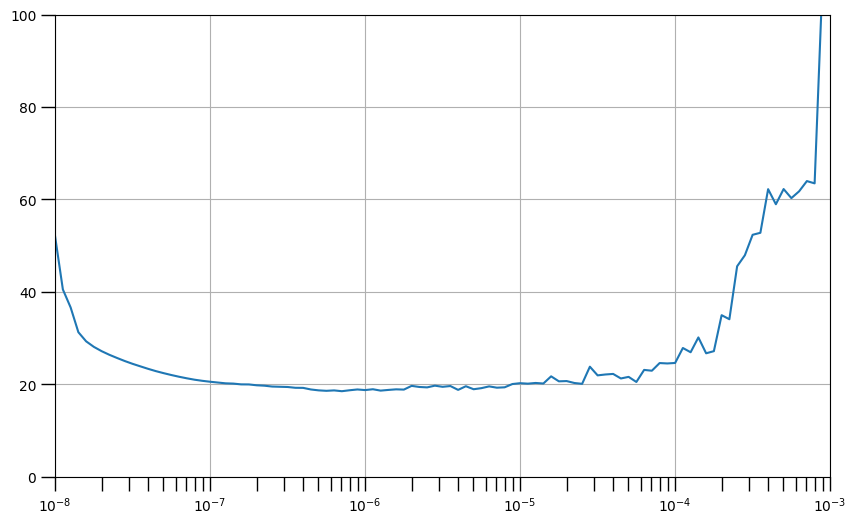

In [11]:
# Define the learning rate array
lrs = 1e-8 * (10 ** (np.arange(100) / 20))

# Set the figure size
plt.figure(figsize=(10, 6))

# Set the grid
plt.grid(True)

# Plot the loss in log scale
plt.semilogx(lrs, history.history["loss"])

# Increase the tickmarks size
plt.tick_params('both', length=10, width=1, which='both')

# Set the plot boundaries
plt.axis([1e-8, 1e-3, 0, 100])

## Train the Model

Now you can proceed to reset and train the model. It is set for 100 epochs in the cell below but feel free to increase it if you want. Laurence got his results in the lectures after 500.

In [12]:
# Reset states generated by Keras
tf.keras.backend.clear_session()

# Reset the weights
model.set_weights(init_weights)

In [13]:
# Set the learning rate
learning_rate = 8e-7

# Set the optimizer 
optimizer = tf.keras.optimizers.SGD(learning_rate=learning_rate, momentum=0.9)

# Set the training parameters
model.compile(loss=tf.keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])

In [14]:
# Train the model
history = model.fit(train_set,epochs=100)

Epoch 1/100
93/93 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - loss: 32.5034 - mae: 33.0003
Epoch 2/100
10/93 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 22.4537 - mae: 22.9460

2024-10-10 15:13:38.848947: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 17224760515236981673
2024-10-10 15:13:38.848989: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 18419711463093621823
2024-10-10 15:13:38.848996: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 3483505175263527210


93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 21.2624 - mae: 21.7564
Epoch 3/100
10/93 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 21.6654 - mae: 22.1603

2024-10-10 15:13:39.986725: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 17224760515236981673
2024-10-10 15:13:39.986760: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 18419711463093621823
2024-10-10 15:13:39.986767: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 3483505175263527210


93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 20.0266 - mae: 20.5190
Epoch 4/100
10/93 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 20.7731 - mae: 21.2671

2024-10-10 15:13:41.249753: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 18419711463093621823


93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 19.3811 - mae: 19.8736
Epoch 5/100
14/93 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 19.6334 - mae: 20.1282

2024-10-10 15:13:42.327797: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 18419711463093621823
2024-10-10 15:13:42.327843: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 3483505175263527210


93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 18.8985 - mae: 19.3931
Epoch 6/100
14/93 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 20.1170 - mae: 20.6139

2024-10-10 15:13:43.342654: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 17224760515236981673
2024-10-10 15:13:43.342693: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 18419711463093621823
2024-10-10 15:13:43.342699: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 3483505175263527210


93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 19.2280 - mae: 19.7228
Epoch 7/100
13/93 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 19.4700 - mae: 19.9616

2024-10-10 15:13:44.515553: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 17224760515236981673
2024-10-10 15:13:44.515596: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 18419711463093621823
2024-10-10 15:13:44.515603: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 3483505175263527210


93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 18.7078 - mae: 19.2007
Epoch 8/100
14/93 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 19.1359 - mae: 19.6279

2024-10-10 15:13:45.741998: I tensorflow/core/framework/local_rendezvous.cc:427] Local rendezvous send item cancelled. Key hash: 10309888268372728505
2024-10-10 15:13:45.742046: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 17224760515236981673
2024-10-10 15:13:45.742052: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 18419711463093621823
2024-10-10 15:13:45.742055: I tensorflow/core/framework/local_rendezvous.cc:427] Local rendezvous send item cancelled. Key hash: 10400616024103305829
2024-10-10 15:13:45.742060: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 3483505175263527210


93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 18.3542 - mae: 18.8467
Epoch 9/100
14/93 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 19.3408 - mae: 19.8364

2024-10-10 15:13:46.904393: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 18419711463093621823


93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 18.5669 - mae: 19.0613
Epoch 10/100
16/93 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 18.8659 - mae: 19.3598

2024-10-10 15:13:47.952830: I tensorflow/core/framework/local_rendezvous.cc:427] Local rendezvous send item cancelled. Key hash: 10309888268372728505
2024-10-10 15:13:47.952874: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 17224760515236981673
2024-10-10 15:13:47.952880: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 18419711463093621823
2024-10-10 15:13:47.952883: I tensorflow/core/framework/local_rendezvous.cc:427] Local rendezvous send item cancelled. Key hash: 10400616024103305829
2024-10-10 15:13:47.952887: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 3483505175263527210


93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 18.1127 - mae: 18.6055
Epoch 11/100
14/93 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 19.2196 - mae: 19.7114

2024-10-10 15:13:48.951565: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 17224760515236981673
2024-10-10 15:13:48.951609: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 18419711463093621823
2024-10-10 15:13:48.951617: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 3483505175263527210


93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 18.7346 - mae: 19.2273
Epoch 12/100
15/93 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 19.0789 - mae: 19.5709

2024-10-10 15:13:49.970062: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 17224760515236981673
2024-10-10 15:13:49.970103: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 18419711463093621823
2024-10-10 15:13:49.970110: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 3483505175263527210


93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 18.2129 - mae: 18.7050
Epoch 13/100
13/93 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 19.2046 - mae: 19.6936

2024-10-10 15:13:51.071038: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 17224760515236981673
2024-10-10 15:13:51.071081: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 18419711463093621823
2024-10-10 15:13:51.071089: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 3483505175263527210


93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 18.2207 - mae: 18.7124
Epoch 14/100
14/93 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 18.7856 - mae: 19.2742

2024-10-10 15:13:52.253845: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 18419711463093621823


93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 17.9541 - mae: 18.4453
Epoch 15/100
13/93 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 19.5299 - mae: 20.0197

2024-10-10 15:13:53.330744: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 17224760515236981673
2024-10-10 15:13:53.330792: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 18419711463093621823
2024-10-10 15:13:53.330799: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 3483505175263527210


93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 18.7901 - mae: 19.2812
Epoch 16/100
19/93 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 19.2373 - mae: 19.7298 

2024-10-10 15:13:54.346279: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 18419711463093621823


93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 18.3473 - mae: 18.8396
Epoch 17/100
17/93 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 19.3754 - mae: 19.8672

2024-10-10 15:13:55.272707: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 18419711463093621823


93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 18.9814 - mae: 19.4745
Epoch 18/100
19/93 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 18.5047 - mae: 18.9992 

2024-10-10 15:13:56.199359: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 17224760515236981673
2024-10-10 15:13:56.199424: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 18419711463093621823
2024-10-10 15:13:56.199435: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 3483505175263527210


93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 18.3902 - mae: 18.8845 
Epoch 19/100
17/93 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 18.6277 - mae: 19.1215

2024-10-10 15:13:56.563574: I tensorflow/core/framework/local_rendezvous.cc:427] Local rendezvous send item cancelled. Key hash: 10309888268372728505
2024-10-10 15:13:56.563622: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 17224760515236981673
2024-10-10 15:13:56.563627: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 18419711463093621823
2024-10-10 15:13:56.563631: I tensorflow/core/framework/local_rendezvous.cc:427] Local rendezvous send item cancelled. Key hash: 10400616024103305829
2024-10-10 15:13:56.563636: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 3483505175263527210


93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 18.3144 - mae: 18.8078
Epoch 20/100
19/93 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 18.9822 - mae: 19.4762

2024-10-10 15:13:57.565158: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 17224760515236981673
2024-10-10 15:13:57.565204: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 18419711463093621823
2024-10-10 15:13:57.565212: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 3483505175263527210


93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 18.4803 - mae: 18.9740
Epoch 21/100
19/93 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 18.9637 - mae: 19.4559

2024-10-10 15:13:58.605943: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 18419711463093621823


93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 18.3812 - mae: 18.8740
Epoch 22/100
14/93 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 19.4444 - mae: 19.9342

2024-10-10 15:13:59.550500: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 17224760515236981673
2024-10-10 15:13:59.550538: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 18419711463093621823
2024-10-10 15:13:59.550545: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 3483505175263527210


93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 18.2978 - mae: 18.7893
Epoch 23/100
18/93 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 18.6087 - mae: 19.0982

2024-10-10 15:14:00.593370: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 3483505175263527210
2024-10-10 15:14:00.593432: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 18419711463093621823


93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 18.1196 - mae: 18.6109
Epoch 24/100
14/93 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 18.9779 - mae: 19.4705

2024-10-10 15:14:01.550960: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 18419711463093621823


93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 18.0221 - mae: 18.5135
Epoch 25/100
16/93 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 19.0373 - mae: 19.5287

2024-10-10 15:14:02.659164: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 17224760515236981673
2024-10-10 15:14:02.659212: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 18419711463093621823
2024-10-10 15:14:02.659220: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 3483505175263527210


93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 18.1442 - mae: 18.6351
Epoch 26/100
10/93 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 19.7098 - mae: 20.2021

2024-10-10 15:14:03.746908: I tensorflow/core/framework/local_rendezvous.cc:427] Local rendezvous send item cancelled. Key hash: 10309888268372728505
2024-10-10 15:14:03.746953: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 17224760515236981673
2024-10-10 15:14:03.746959: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 18419711463093621823
2024-10-10 15:14:03.746962: I tensorflow/core/framework/local_rendezvous.cc:427] Local rendezvous send item cancelled. Key hash: 10400616024103305829
2024-10-10 15:14:03.746966: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 3483505175263527210


93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 18.1163 - mae: 18.6072
Epoch 27/100
19/93 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 18.7099 - mae: 19.2008

2024-10-10 15:14:04.779349: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 17224760515236981673
2024-10-10 15:14:04.779390: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 18419711463093621823
2024-10-10 15:14:04.779397: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 3483505175263527210


93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 18.0919 - mae: 18.5832
Epoch 28/100
18/93 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 18.4149 - mae: 18.9059

2024-10-10 15:14:05.707982: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 17224760515236981673
2024-10-10 15:14:05.708034: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 18419711463093621823
2024-10-10 15:14:05.708043: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 3483505175263527210


93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 17.7908 - mae: 18.2828
Epoch 29/100
20/93 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 18.3896 - mae: 18.8805

2024-10-10 15:14:06.597421: I tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[StatefulPartitionedCall/Shape/_6]]
2024-10-10 15:14:06.597468: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 17224760515236981673
2024-10-10 15:14:06.597474: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 18419711463093621823
2024-10-10 15:14:06.597479: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 3483505175263527210


93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 17.8005 - mae: 18.2920
Epoch 30/100
16/93 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 18.6945 - mae: 19.1841

2024-10-10 15:14:07.568923: I tensorflow/core/framework/local_rendezvous.cc:427] Local rendezvous send item cancelled. Key hash: 10309888268372728505
2024-10-10 15:14:07.568969: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 17224760515236981673
2024-10-10 15:14:07.568975: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 18419711463093621823
2024-10-10 15:14:07.568977: I tensorflow/core/framework/local_rendezvous.cc:427] Local rendezvous send item cancelled. Key hash: 10400616024103305829
2024-10-10 15:14:07.568989: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 3483505175263527210


93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 17.7624 - mae: 18.2528
Epoch 31/100
14/93 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 18.8053 - mae: 19.2979

2024-10-10 15:14:08.732353: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 17224760515236981673
2024-10-10 15:14:08.732395: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 18419711463093621823
2024-10-10 15:14:08.732401: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 3483505175263527210


93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 17.7597 - mae: 18.2514
Epoch 32/100
15/93 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 18.7727 - mae: 19.2646

2024-10-10 15:14:09.932144: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 17224760515236981673
2024-10-10 15:14:09.932189: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 18419711463093621823
2024-10-10 15:14:09.932196: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 3483505175263527210


93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 17.7535 - mae: 18.2450
Epoch 33/100
14/93 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 18.7487 - mae: 19.2396

2024-10-10 15:14:11.039656: I tensorflow/core/framework/local_rendezvous.cc:427] Local rendezvous send item cancelled. Key hash: 10309888268372728505
2024-10-10 15:14:11.039703: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 17224760515236981673
2024-10-10 15:14:11.039709: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 18419711463093621823
2024-10-10 15:14:11.039712: I tensorflow/core/framework/local_rendezvous.cc:427] Local rendezvous send item cancelled. Key hash: 10400616024103305829
2024-10-10 15:14:11.039716: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 3483505175263527210


93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 17.6872 - mae: 18.1789
Epoch 34/100
16/93 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 18.5607 - mae: 19.0516

2024-10-10 15:14:12.270880: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 17224760515236981673
2024-10-10 15:14:12.270924: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 18419711463093621823
2024-10-10 15:14:12.270931: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 3483505175263527210


93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 17.6635 - mae: 18.1556
Epoch 35/100
16/93 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 18.6172 - mae: 19.1068

2024-10-10 15:14:13.480150: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 17224760515236981673
2024-10-10 15:14:13.480194: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 18419711463093621823
2024-10-10 15:14:13.480201: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 3483505175263527210


93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 17.6702 - mae: 18.1619
Epoch 36/100
17/93 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 18.5639 - mae: 19.0538

2024-10-10 15:14:14.508866: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 18419711463093621823


93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 17.7031 - mae: 18.1944
Epoch 37/100
17/93 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 18.3976 - mae: 18.8847

2024-10-10 15:14:15.552889: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 17224760515236981673
2024-10-10 15:14:15.552930: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 18419711463093621823
2024-10-10 15:14:15.552937: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 3483505175263527210


93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 17.7333 - mae: 18.2238
Epoch 38/100
19/93 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 18.3593 - mae: 18.8510

2024-10-10 15:14:16.559193: I tensorflow/core/framework/local_rendezvous.cc:427] Local rendezvous send item cancelled. Key hash: 10309888268372728505
2024-10-10 15:14:16.559235: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 17224760515236981673
2024-10-10 15:14:16.559242: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 18419711463093621823
2024-10-10 15:14:16.559245: I tensorflow/core/framework/local_rendezvous.cc:427] Local rendezvous send item cancelled. Key hash: 10400616024103305829
2024-10-10 15:14:16.559249: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 3483505175263527210


93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 17.6534 - mae: 18.1454
Epoch 39/100
20/93 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 18.0570 - mae: 18.5454

2024-10-10 15:14:17.455472: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 18419711463093621823


93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 17.5219 - mae: 18.0114
Epoch 40/100
18/93 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 18.2347 - mae: 18.7241

2024-10-10 15:14:18.395249: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 17224760515236981673
2024-10-10 15:14:18.395293: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 18419711463093621823
2024-10-10 15:14:18.395301: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 3483505175263527210


93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 17.5182 - mae: 18.0085
Epoch 41/100
18/93 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 18.1199 - mae: 18.6050

2024-10-10 15:14:19.298881: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 17224760515236981673
2024-10-10 15:14:19.298927: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 18419711463093621823
2024-10-10 15:14:19.298934: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 3483505175263527210


93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 17.5700 - mae: 18.0591
Epoch 42/100
13/93 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 18.5706 - mae: 19.0544

2024-10-10 15:14:20.335065: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 17224760515236981673
2024-10-10 15:14:20.335104: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 18419711463093621823
2024-10-10 15:14:20.335112: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 3483505175263527210


93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 17.5725 - mae: 18.0605
Epoch 43/100
19/93 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 18.0329 - mae: 18.5159

2024-10-10 15:14:21.366603: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 18419711463093621823


93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 17.5055 - mae: 17.9934
Epoch 44/100
15/93 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 18.2848 - mae: 18.7676

2024-10-10 15:14:22.296080: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 18419711463093621823


93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 17.5084 - mae: 17.9971
Epoch 45/100
18/93 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 18.0933 - mae: 18.5795

2024-10-10 15:14:23.343627: I tensorflow/core/framework/local_rendezvous.cc:427] Local rendezvous send item cancelled. Key hash: 10309888268372728505
2024-10-10 15:14:23.343680: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 17224760515236981673
2024-10-10 15:14:23.343686: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 18419711463093621823
2024-10-10 15:14:23.343689: I tensorflow/core/framework/local_rendezvous.cc:427] Local rendezvous send item cancelled. Key hash: 10400616024103305829
2024-10-10 15:14:23.343693: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 3483505175263527210


93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 17.4749 - mae: 17.9636
Epoch 46/100
17/93 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 18.4169 - mae: 18.9040

2024-10-10 15:14:24.338812: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 18419711463093621823


93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 17.5571 - mae: 18.0454
Epoch 47/100
14/93 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 18.4405 - mae: 18.9255

2024-10-10 15:14:25.376728: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 17224760515236981673
2024-10-10 15:14:25.376774: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 18419711463093621823
2024-10-10 15:14:25.376782: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 3483505175263527210


93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 17.4605 - mae: 17.9487
Epoch 48/100
13/93 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 18.6088 - mae: 19.0978

2024-10-10 15:14:26.649365: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 18419711463093621823


93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 17.4777 - mae: 17.9678
Epoch 49/100
14/93 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 18.5884 - mae: 19.0713

2024-10-10 15:14:27.937073: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 17224760515236981673
2024-10-10 15:14:27.937123: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 18419711463093621823
2024-10-10 15:14:27.937130: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 3483505175263527210


93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 17.4846 - mae: 17.9728 
Epoch 50/100
16/93 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 18.3301 - mae: 18.8157

2024-10-10 15:14:28.494192: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 17224760515236981673
2024-10-10 15:14:28.494243: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 18419711463093621823
2024-10-10 15:14:28.494251: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 3483505175263527210


93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 17.4603 - mae: 17.9494
Epoch 51/100
10/93 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 18.8937 - mae: 19.3796

2024-10-10 15:14:29.653022: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 17224760515236981673
2024-10-10 15:14:29.653070: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 18419711463093621823
2024-10-10 15:14:29.653078: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 3483505175263527210


93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 17.4693 - mae: 17.9592
Epoch 52/100
10/93 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 18.9213 - mae: 19.4058

2024-10-10 15:14:30.872265: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 17224760515236981673
2024-10-10 15:14:30.872313: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 18419711463093621823
2024-10-10 15:14:30.872321: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 3483505175263527210


93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 17.4299 - mae: 17.9191
Epoch 53/100
15/93 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 18.3070 - mae: 18.7919

2024-10-10 15:14:32.205984: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 17224760515236981673
2024-10-10 15:14:32.206032: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 18419711463093621823
2024-10-10 15:14:32.206040: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 3483505175263527210


93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 17.4222 - mae: 17.9120
Epoch 54/100
 9/93 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 18.8382 - mae: 19.3232

2024-10-10 15:14:33.383050: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 18419711463093621823


93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 17.3744 - mae: 17.8639
Epoch 55/100
11/93 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 18.7504 - mae: 19.2447

2024-10-10 15:14:34.530532: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 18419711463093621823


93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 17.2965 - mae: 17.7888
Epoch 56/100
12/93 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 18.6147 - mae: 19.1020

2024-10-10 15:14:35.754789: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 18419711463093621823


93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 17.3451 - mae: 17.8341
Epoch 57/100
10/93 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 18.8985 - mae: 19.3887

2024-10-10 15:14:37.058275: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 18419711463093621823


93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 17.4017 - mae: 17.8933
Epoch 58/100
 9/93 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 18.8478 - mae: 19.3295

2024-10-10 15:14:38.350012: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 18419711463093621823


93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 17.3201 - mae: 17.8080
Epoch 59/100
18/93 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 17.8662 - mae: 18.3567

2024-10-10 15:14:39.548377: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 18419711463093621823


93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 17.2592 - mae: 17.7492
Epoch 60/100
17/93 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 18.0434 - mae: 18.5305

2024-10-10 15:14:40.552341: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 18419711463093621823


93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 17.3398 - mae: 17.8291
Epoch 61/100
12/93 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 18.5441 - mae: 19.0352

2024-10-10 15:14:41.662132: I tensorflow/core/framework/local_rendezvous.cc:427] Local rendezvous send item cancelled. Key hash: 10309888268372728505
2024-10-10 15:14:41.662192: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 17224760515236981673
2024-10-10 15:14:41.662197: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 18419711463093621823
2024-10-10 15:14:41.662218: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 3483505175263527210


93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 17.2757 - mae: 17.7671
Epoch 62/100
17/93 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 17.9864 - mae: 18.4757

2024-10-10 15:14:42.893597: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 17224760515236981673
2024-10-10 15:14:42.893644: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 18419711463093621823
2024-10-10 15:14:42.893665: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 3483505175263527210


93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 17.2598 - mae: 17.7504
Epoch 63/100
16/93 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 18.0658 - mae: 18.5579

2024-10-10 15:14:43.961640: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 17224760515236981673
2024-10-10 15:14:43.961691: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 18419711463093621823
2024-10-10 15:14:43.961701: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 3483505175263527210


93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 17.2503 - mae: 17.7406
Epoch 64/100
13/93 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 18.3679 - mae: 18.8583

2024-10-10 15:14:45.241637: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 18419711463093621823


93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 17.2567 - mae: 17.7473
Epoch 65/100
14/93 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 18.1759 - mae: 18.6616

2024-10-10 15:14:46.446815: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 18419711463093621823


93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 17.2061 - mae: 17.6959
Epoch 66/100
16/93 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 17.9270 - mae: 18.4157

2024-10-10 15:14:47.464289: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 17224760515236981673
2024-10-10 15:14:47.464334: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 18419711463093621823
2024-10-10 15:14:47.464342: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 3483505175263527210


93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 17.1680 - mae: 17.6580
Epoch 67/100
16/93 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 17.9620 - mae: 18.4557

2024-10-10 15:14:48.481201: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 17224760515236981673
2024-10-10 15:14:48.481240: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 18419711463093621823
2024-10-10 15:14:48.481257: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 3483505175263527210


93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 17.2070 - mae: 17.6994
Epoch 68/100
17/93 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 17.8636 - mae: 18.3528

2024-10-10 15:14:49.460449: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 18419711463093621823


93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 17.2316 - mae: 17.7215
Epoch 69/100
18/93 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 17.6868 - mae: 18.1799

2024-10-10 15:14:50.391394: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 17224760515236981673
2024-10-10 15:14:50.391443: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 18419711463093621823
2024-10-10 15:14:50.391450: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 3483505175263527210


93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 17.1528 - mae: 17.6439
Epoch 70/100
16/93 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 17.9424 - mae: 18.4324

2024-10-10 15:14:51.312392: I tensorflow/core/framework/local_rendezvous.cc:427] Local rendezvous send item cancelled. Key hash: 10309888268372728505
2024-10-10 15:14:51.312449: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 17224760515236981673
2024-10-10 15:14:51.312468: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 18419711463093621823
2024-10-10 15:14:51.312490: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 3483505175263527210


93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 17.1466 - mae: 17.6372
Epoch 71/100
18/93 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 17.7719 - mae: 18.2596

2024-10-10 15:14:52.228358: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 17224760515236981673
2024-10-10 15:14:52.228401: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 18419711463093621823
2024-10-10 15:14:52.228409: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 3483505175263527210


93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 17.1647 - mae: 17.6542
Epoch 72/100
20/93 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 17.5037 - mae: 17.9942

2024-10-10 15:14:53.153327: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 18419711463093621823
2024-10-10 15:14:53.153389: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 3483505175263527210


93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 17.0793 - mae: 17.5703
Epoch 73/100
17/93 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 17.8961 - mae: 18.3903

2024-10-10 15:14:54.022810: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 17224760515236981673
2024-10-10 15:14:54.022856: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 18419711463093621823
2024-10-10 15:14:54.022863: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 3483505175263527210


93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 17.1986 - mae: 17.6896
Epoch 74/100
17/93 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 17.7451 - mae: 18.2330

2024-10-10 15:14:54.944414: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 17224760515236981673
2024-10-10 15:14:54.944461: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 18419711463093621823
2024-10-10 15:14:54.944468: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 3483505175263527210


93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 17.1309 - mae: 17.6204
Epoch 75/100
18/93 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 17.5988 - mae: 18.0886

2024-10-10 15:14:55.927985: I tensorflow/core/framework/local_rendezvous.cc:427] Local rendezvous send item cancelled. Key hash: 10309888268372728505
2024-10-10 15:14:55.928029: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 17224760515236981673
2024-10-10 15:14:55.928035: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 18419711463093621823
2024-10-10 15:14:55.928037: I tensorflow/core/framework/local_rendezvous.cc:427] Local rendezvous send item cancelled. Key hash: 10400616024103305829
2024-10-10 15:14:55.928042: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 3483505175263527210


93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 17.1183 - mae: 17.6089
Epoch 76/100
19/93 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 17.4984 - mae: 17.9832

2024-10-10 15:14:56.870876: I tensorflow/core/framework/local_rendezvous.cc:427] Local rendezvous send item cancelled. Key hash: 10309888268372728505
2024-10-10 15:14:56.870924: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 17224760515236981673
2024-10-10 15:14:56.870929: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 18419711463093621823
2024-10-10 15:14:56.870932: I tensorflow/core/framework/local_rendezvous.cc:427] Local rendezvous send item cancelled. Key hash: 10400616024103305829
2024-10-10 15:14:56.870937: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 3483505175263527210


93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 17.1114 - mae: 17.5997
Epoch 77/100
17/93 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 17.6574 - mae: 18.1479

2024-10-10 15:14:57.780210: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 17224760515236981673
2024-10-10 15:14:57.780260: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 18419711463093621823
2024-10-10 15:14:57.780269: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 3483505175263527210


93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 17.1210 - mae: 17.6119
Epoch 78/100
15/93 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 17.8088 - mae: 18.2965

2024-10-10 15:14:58.843869: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 18419711463093621823


93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 17.0967 - mae: 17.5859
Epoch 79/100
17/93 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 17.6283 - mae: 18.1132

2024-10-10 15:14:59.787434: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 17224760515236981673
2024-10-10 15:14:59.787479: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 18419711463093621823
2024-10-10 15:14:59.787488: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 3483505175263527210


93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 17.1241 - mae: 17.6122 
Epoch 80/100
17/93 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 17.6936 - mae: 18.1821

2024-10-10 15:15:00.143052: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 17224760515236981673
2024-10-10 15:15:00.143098: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 18419711463093621823
2024-10-10 15:15:00.143105: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 3483505175263527210


93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 17.0863 - mae: 17.5759
Epoch 81/100
18/93 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 17.5582 - mae: 18.0463

2024-10-10 15:15:01.052627: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 17224760515236981673
2024-10-10 15:15:01.052674: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 18419711463093621823
2024-10-10 15:15:01.052681: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 3483505175263527210


93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 17.1229 - mae: 17.6122
Epoch 82/100
17/93 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 17.5848 - mae: 18.0757

2024-10-10 15:15:01.963745: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 17224760515236981673
2024-10-10 15:15:01.963791: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 18419711463093621823
2024-10-10 15:15:01.963798: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 3483505175263527210


93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 17.1042 - mae: 17.5947
Epoch 83/100
18/93 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 17.5149 - mae: 18.0042

2024-10-10 15:15:02.889474: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 18419711463093621823


93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 17.0763 - mae: 17.5668
Epoch 84/100
16/93 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 17.7023 - mae: 18.1951

2024-10-10 15:15:03.864020: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 17224760515236981673
2024-10-10 15:15:03.864067: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 18419711463093621823
2024-10-10 15:15:03.864075: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 3483505175263527210


93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 17.0023 - mae: 17.4936
Epoch 85/100
19/93 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 17.4841 - mae: 17.9734

2024-10-10 15:15:04.867190: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 17224760515236981673
2024-10-10 15:15:04.867233: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 18419711463093621823
2024-10-10 15:15:04.867240: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 3483505175263527210


93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 17.0566 - mae: 17.5467
Epoch 86/100
18/93 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 17.4526 - mae: 17.9399

2024-10-10 15:15:05.790077: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 18419711463093621823


93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 17.0392 - mae: 17.5286
Epoch 87/100
19/93 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 17.3833 - mae: 17.8718

2024-10-10 15:15:06.755336: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 17224760515236981673
2024-10-10 15:15:06.755386: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 18419711463093621823
2024-10-10 15:15:06.755393: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 3483505175263527210


93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 17.0083 - mae: 17.4982
Epoch 88/100
17/93 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 17.6267 - mae: 18.1153

2024-10-10 15:15:07.721823: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 18419711463093621823


93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 17.0168 - mae: 17.5050
Epoch 89/100
17/93 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 17.6506 - mae: 18.1397

2024-10-10 15:15:08.713472: I tensorflow/core/framework/local_rendezvous.cc:427] Local rendezvous send item cancelled. Key hash: 10309888268372728505
2024-10-10 15:15:08.713524: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 17224760515236981673
2024-10-10 15:15:08.713530: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 18419711463093621823
2024-10-10 15:15:08.713533: I tensorflow/core/framework/local_rendezvous.cc:427] Local rendezvous send item cancelled. Key hash: 10400616024103305829
2024-10-10 15:15:08.713537: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 3483505175263527210


93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 17.0230 - mae: 17.5125
Epoch 90/100
15/93 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 17.9063 - mae: 18.3908

2024-10-10 15:15:09.693407: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 18419711463093621823


93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 17.0174 - mae: 17.5052
Epoch 91/100
17/93 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 17.7050 - mae: 18.1942

2024-10-10 15:15:10.722043: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 17224760515236981673
2024-10-10 15:15:10.722089: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 18419711463093621823
2024-10-10 15:15:10.722097: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 3483505175263527210


93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 17.0151 - mae: 17.5044
Epoch 92/100
16/93 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 17.8274 - mae: 18.3184

2024-10-10 15:15:11.720126: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 17224760515236981673
2024-10-10 15:15:11.720174: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 18419711463093621823
2024-10-10 15:15:11.720185: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 3483505175263527210


93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 17.0898 - mae: 17.5813
Epoch 93/100
18/93 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 17.6112 - mae: 18.0981

2024-10-10 15:15:12.780082: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 18419711463093621823


93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 17.0015 - mae: 17.4901
Epoch 94/100
16/93 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 17.7243 - mae: 18.2126

2024-10-10 15:15:13.741084: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 18419711463093621823


93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 17.0380 - mae: 17.5292
Epoch 95/100
11/93 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 18.2566 - mae: 18.7479

2024-10-10 15:15:14.781478: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 17224760515236981673
2024-10-10 15:15:14.781524: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 18419711463093621823
2024-10-10 15:15:14.781531: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 3483505175263527210


93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 17.0029 - mae: 17.4928
Epoch 96/100
15/93 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 17.6920 - mae: 18.1840

2024-10-10 15:15:15.872023: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 18419711463093621823


93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 16.9523 - mae: 17.4432
Epoch 97/100
16/93 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 17.7027 - mae: 18.1908

2024-10-10 15:15:16.878358: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 18419711463093621823


93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 16.9809 - mae: 17.4703
Epoch 98/100
15/93 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 17.7003 - mae: 18.1895

2024-10-10 15:15:17.873590: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 18419711463093621823


93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 16.9483 - mae: 17.4389
Epoch 99/100
18/93 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 17.4370 - mae: 17.9279

2024-10-10 15:15:18.842683: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 18419711463093621823


93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 16.9426 - mae: 17.4334
Epoch 100/100
16/93 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 17.6475 - mae: 18.1338

2024-10-10 15:15:19.806406: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 17224760515236981673
2024-10-10 15:15:19.806452: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 18419711463093621823
2024-10-10 15:15:19.806460: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 3483505175263527210


93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 16.9883 - mae: 17.4767


2024-10-10 15:15:20.792875: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 18419711463093621823


You can visualize the training and see if the loss and MAE are still trending down.

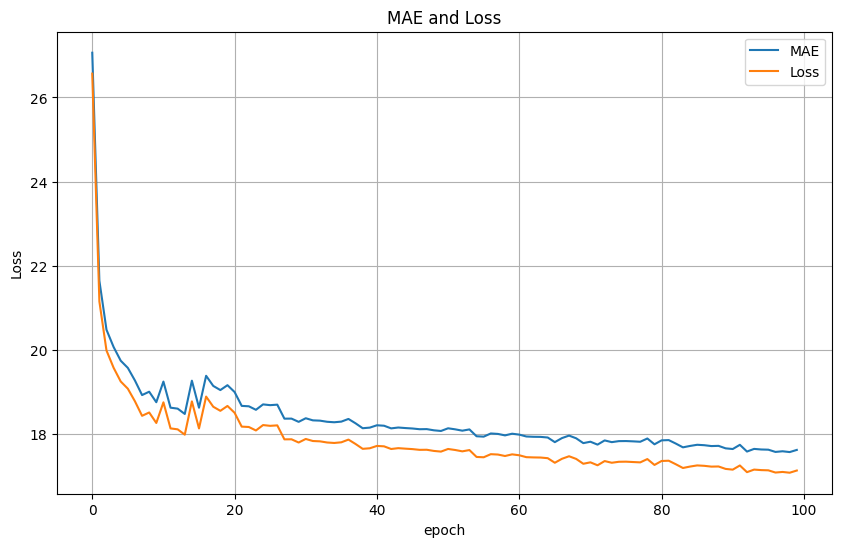

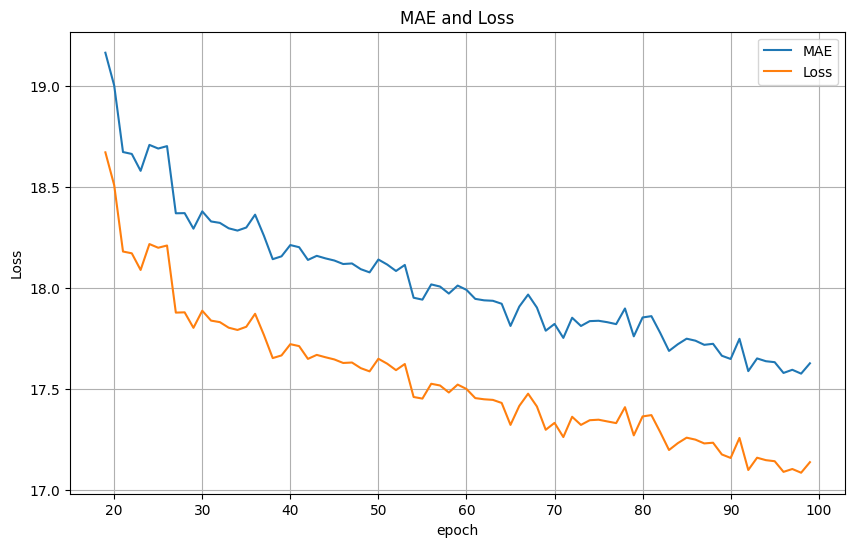

In [15]:
# Get mae and loss from history log
mae=history.history['mae']
loss=history.history['loss']

# Get number of epochs
epochs=range(len(loss)) 

# Plot mae and loss
plot_series(
    x=epochs, 
    y=(mae, loss), 
    title='MAE and Loss', 
    xlabel='epoch',
    ylabel='Loss',
    legend=['MAE', 'Loss']
    )

# Only plot the last 80% of the epochs
zoom_split = int(epochs[-1] * 0.2)
epochs_zoom = epochs[zoom_split:]
mae_zoom = mae[zoom_split:]
loss_zoom = loss[zoom_split:]

# Plot zoomed mae and loss
plot_series(
    x=epochs_zoom, 
    y=(mae_zoom, loss_zoom), 
    title='MAE and Loss', 
    xlabel='epoch',
    ylabel='Loss',
    legend=['MAE', 'Loss']
    )

## Model Prediction

As before, you can get the predictions for the validation set time range and compute the metrics.

In [16]:
def model_forecast(model, series, window_size, batch_size):
    """Uses an input model to generate predictions on data windows

    Args:
      model (TF Keras Model) - model that accepts data windows
      series (array of float) - contains the values of the time series
      window_size (int) - the number of time steps to include in the window
      batch_size (int) - the batch size

    Returns:
      forecast (numpy array) - array containing predictions
    """

    # Add an axis for the feature dimension of RNN layers
    series = tf.expand_dims(series, axis=-1)
    
    # Generate a TF Dataset from the series values
    dataset = tf.data.Dataset.from_tensor_slices(series)

    # Window the data but only take those with the specified size
    dataset = dataset.window(window_size, shift=1, drop_remainder=True)

    # Flatten the windows by putting its elements in a single batch
    dataset = dataset.flat_map(lambda w: w.batch(window_size))
    
    # Create batches of windows
    dataset = dataset.batch(batch_size).prefetch(1)
    
    # Get predictions on the entire dataset
    forecast = model.predict(dataset, verbose=0)
    
    return forecast

W0000 00:00:1728584121.246350  300586 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1728584121.251422  300586 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1728584121.252819  300586 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1728584121.254097  300586 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1728584121.255368  300586 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1728584121.256661  300586 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1728584121.257950  300586 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1728584121.259375  300586 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1728584121.260775  300586 gp

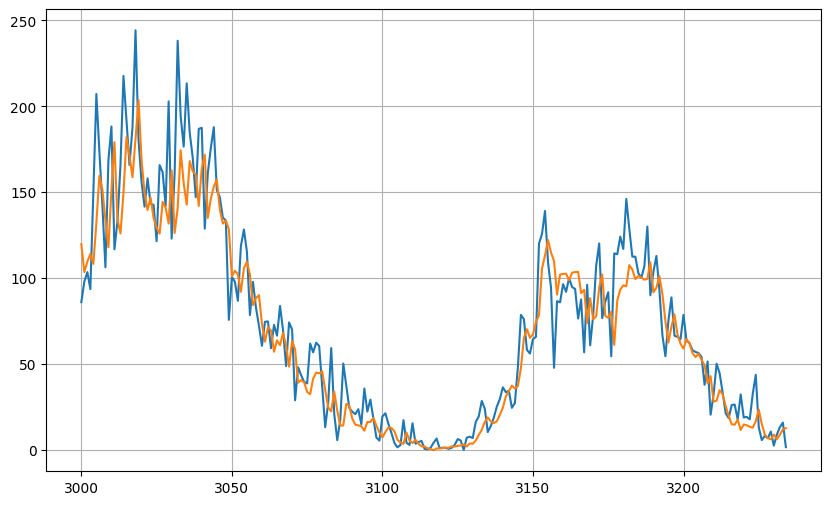

In [17]:
# Reduce the original series
forecast_series = series[split_time-window_size:-1]

# Use helper function to generate predictions
forecast = model_forecast(model, forecast_series, window_size, batch_size)

# Drop single dimensional axis
results = forecast.squeeze()

# Plot the results
plot_series(time_valid, (x_valid, results))

In [18]:
# Compute the MAE
print(tf.keras.metrics.mae(x_valid, results).numpy())

14.943964


## Wrap Up

This concludes the final practice lab for this course! You implemented a deep and complex architecture composed of CNNs, RNNs, and DNNs. You'll be using the skills you developed throughout this course to complete the final assignment. Keep it up!